In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.spatial.transform import Rotation

import collections

import sys
sys.path.append('../Tianwen')

import ccsds

plt.rcParams['figure.figsize'] = (7, 3.5)
plt.rcParams['figure.facecolor'] = 'w'

from construct import *

AOSFrame = Struct(
    'primary_header' / ccsds.AOSPrimaryHeader,
    'm_pdu_header' / ccsds.M_PDU_Header,
    'm_pdu_packet_zone' / ccsds.GreedyBytes
)

def timestamps(data):
    t = data[:, :4].view('uint32').byteswap().ravel().astype('float')
    t_frac = data[:, 4:6].view('uint16').byteswap().ravel().astype('float')
    t = t + t_frac / 2**16
    return np.datetime64('2000-01-01T12:00:00') + (1e9 * t) * np.timedelta64(1, 'ns')

In [2]:
frames = np.concatenate((
    np.fromfile('lunar_flashlight_frames_20221212_170854Z.u8', 'uint8'),
    np.fromfile('lunar_flashlight_frames_20221212_170854Z_2.u8', 'uint8'),
    )).reshape(-1, 5*223-2)
frames.shape

(161, 1113)

## AOS frames

Frames are AOS frames using spacecraft ID `0x81` (assigned to [Lunar-Flashlight in SANA registry](https://sanaregistry.org/r/spacecraftid/records/14178)). Only virtual channel 2 is in use. There is no Operational Control Field or Insert Zone.

In [3]:
aos = [ccsds.AOSPrimaryHeader.parse(f) for f in frames]
scid = [a.spacecraft_id for a in aos]
vcid = np.array([a.virtual_channel_id for a in aos])
vcfc = np.array([a.virtual_channel_frame_count for a in aos])
aos[:5]

[Container(transfer_frame_version_number=1, spacecraft_id=129, virtual_channel_id=2, virtual_channel_frame_count=6212, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=129, virtual_channel_id=2, virtual_channel_frame_count=6213, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=129, virtual_channel_id=2, virtual_channel_frame_count=6214, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=129, virtual_channel_id=2, virtual_channel_frame_count=6215, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=129, virtual_channel_id=2, virtual_channel_frame_count=6216, replay_flag=False, vc_frame_count_usage_flag=

In [4]:
collections.Counter(scid)

Counter({129: 161})

In [5]:
collections.Counter(vcid)

Counter({2: 161})

In [6]:
frame_duration = (5*223*8 + 4 + 32) * 6 / 48e3
frame_duration

1.1195

In [7]:
frame_duration * (frames.shape[0] + 1)

181.35899999999998

## VC2

Virtual channel 2 contains Space Packets using M_PDU. There are no idle packets. All the packets have a secondary header which includes a 48-bit timestamp that gives the number of `1/2**16` second counts elapsed since the J2000 epoch (2000-01-01 12:00:00). Interestingly, there is an offset of one or two minute between the timestamps of the different APIDs.

In [8]:
frame_loss_vc2 = np.sum(np.diff(vcfc[vcid == 2]) - 1)
frame_loss_vc2

1

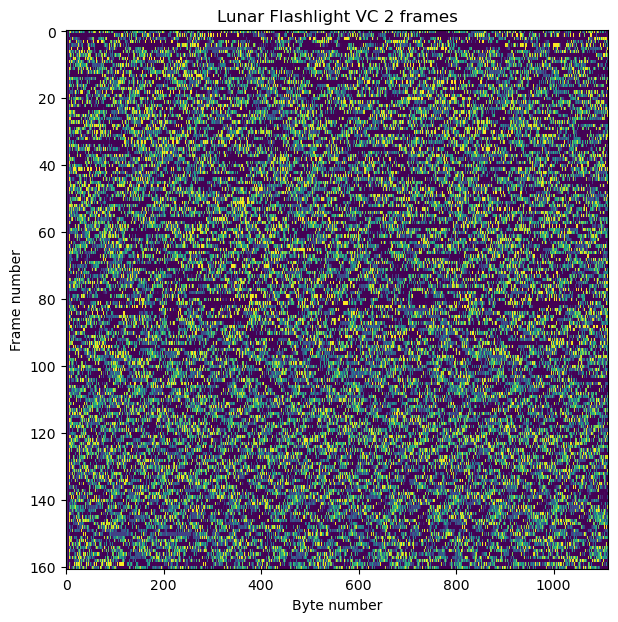

In [9]:
plt.figure(figsize=(7, 7))
plt.imshow(frames[vcid == 2], aspect='auto', interpolation='none')
plt.title('Lunar Flashlight VC 2 frames')
plt.ylabel('Frame number')
plt.xlabel('Byte number');

In [10]:
packets = list(ccsds.extract_space_packets([AOSFrame.parse(f) for f in frames], 0x81, 2))
packet_headers = [ccsds.SpacePacketPrimaryHeader.parse(p) for p in packets]

/home/daniel/jupyter_notebooks/Lunar_Flashlight/../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 129 VC 2] Broken stream. Last frame count 6270, current frame count 6272
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')


In [11]:
packet_headers[:10]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=6, sequence_flags=3, packet_sequence_count_or_name=8381, data_length=69),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=7, sequence_flags=3, packet_sequence_count_or_name=5713, data_length=437),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=10, sequence_flags=3, packet_sequence_count_or_name=9206, data_length=88),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=98, sequence_flags=3, packet_sequence_count_or_name=7539, data_length=38),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=99, sequence_flags=3, packet_sequence_count_or_name=11238, data_length=17),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=1, sequence_flags=3, packet_sequence_count_or_name=3248, data_length=33),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=6, sequence_flags=3

In [12]:
apids = collections.Counter([p.APID for p in packet_headers])
apids

Counter({6: 86,
         7: 51,
         10: 85,
         98: 85,
         99: 85,
         1: 69,
         13: 17,
         3: 1,
         11: 1,
         8: 3,
         2: 1,
         0: 3})

In [13]:
all([p.secondary_header_flag for p in packet_headers])

True

In [14]:
for apid in apids:
    print('APID', apid)
    print('data_lengths', collections.Counter([p.data_length for p in packet_headers if p.APID == apid]))

APID 6
data_lengths Counter({69: 86})
APID 7
data_lengths Counter({437: 51})
APID 10
data_lengths Counter({88: 85})
APID 98
data_lengths Counter({34: 26, 29: 21, 26: 15, 27: 13, 38: 3, 24: 3, 44: 2, 61: 2})
APID 99
data_lengths Counter({17: 54, 23: 31})
APID 1
data_lengths Counter({2041: 61, 33: 3, 94: 3, 1021: 2})
APID 13
data_lengths Counter({158: 17})
APID 3
data_lengths Counter({41: 1})
APID 11
data_lengths Counter({149: 1})
APID 8
data_lengths Counter({176: 3})
APID 2
data_lengths Counter({41: 1})
APID 0
data_lengths Counter({80: 3})


In [15]:
by_apid = {}
for apid in apids:
    ps = [p for p in packets if ccsds.SpacePacketPrimaryHeader.parse(p).APID == apid]
    max_len = max([len(p) for p in ps])
    a = np.zeros((len(ps), max_len), 'uint8')
    for j, p in enumerate(ps):
        a[j, :len(p[6:])] = list(p[6:])
    by_apid[apid] = a

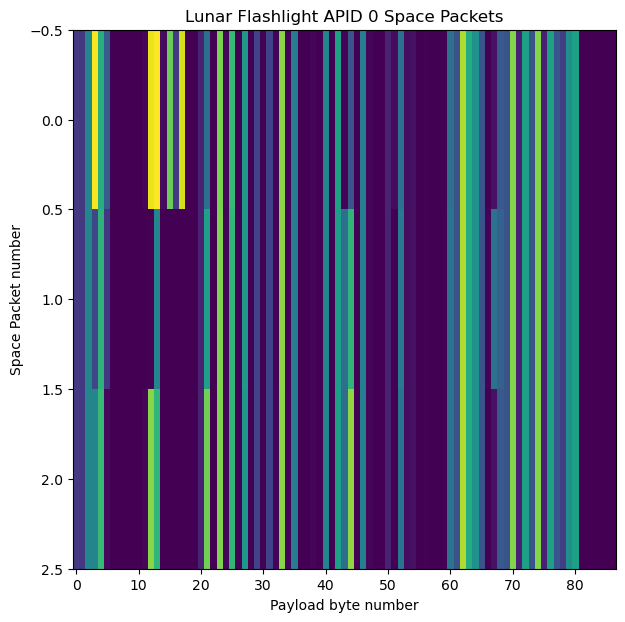

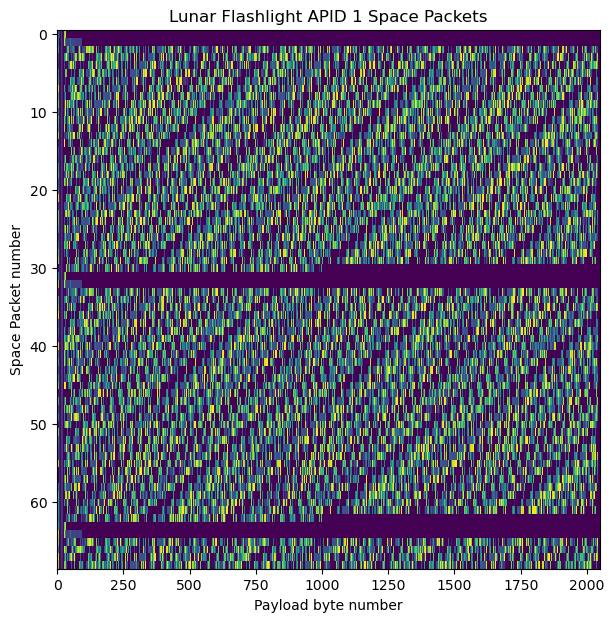

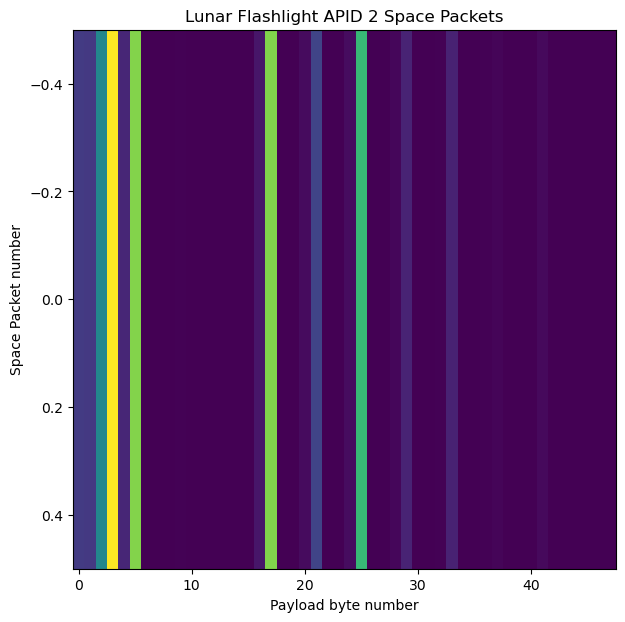

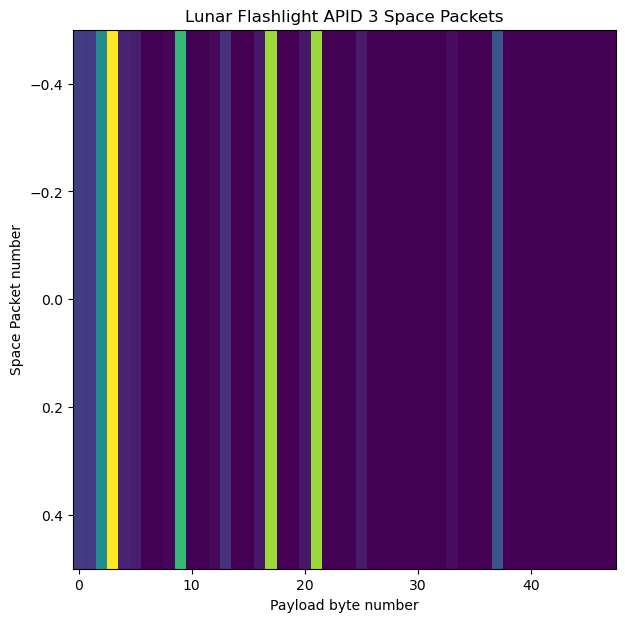

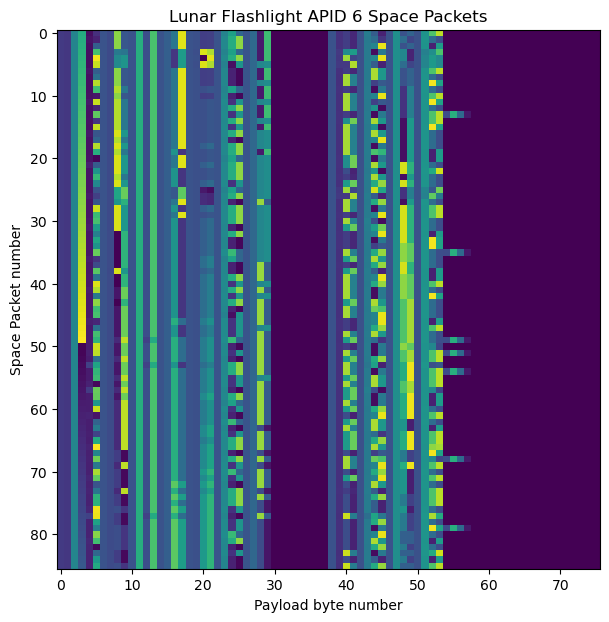

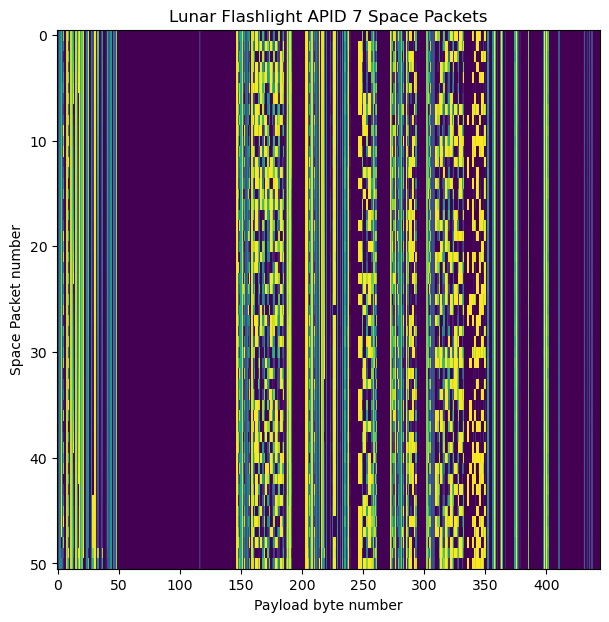

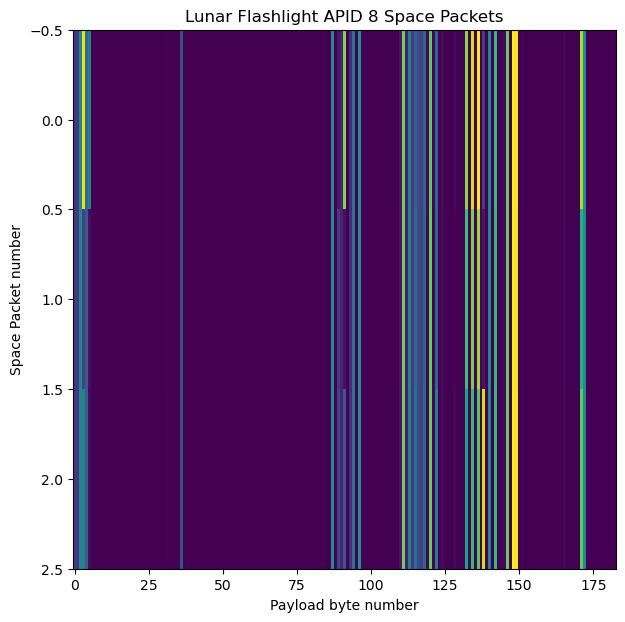

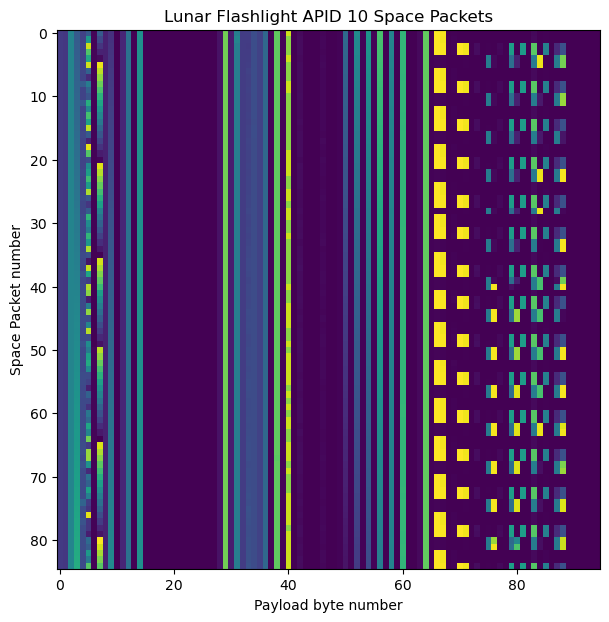

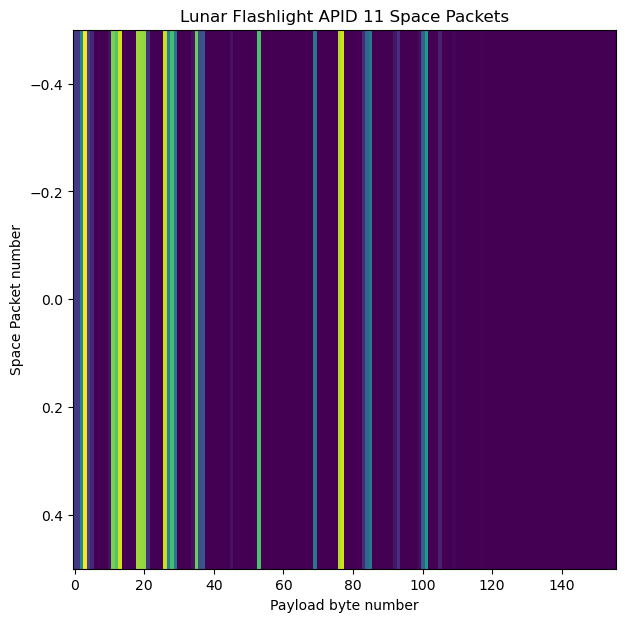

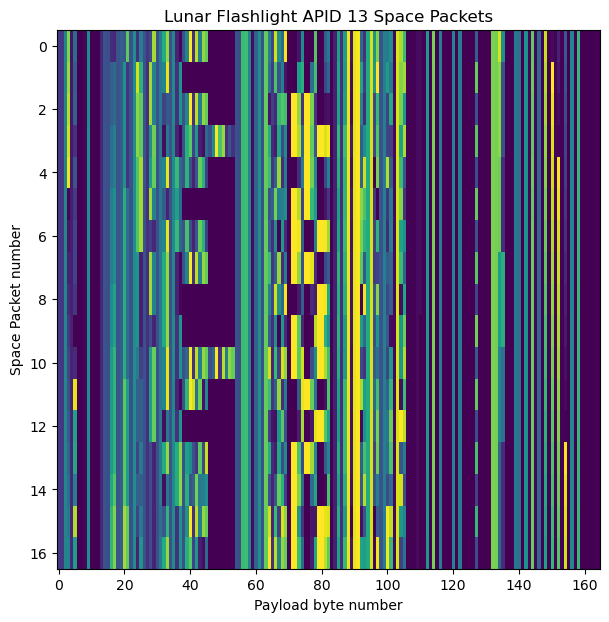

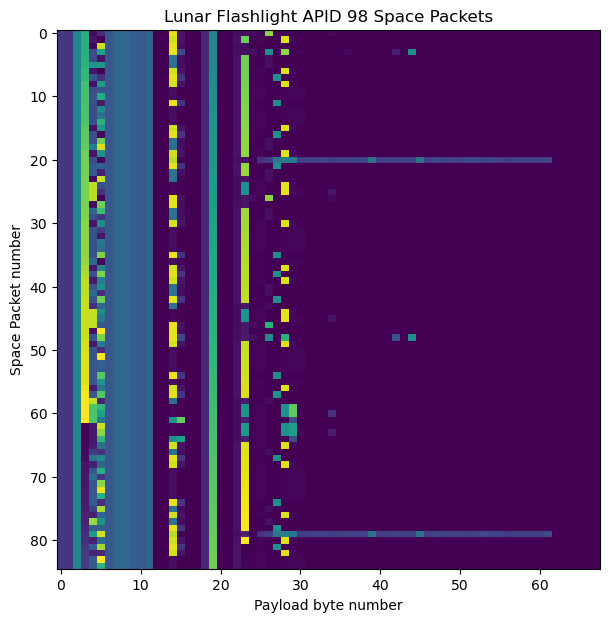

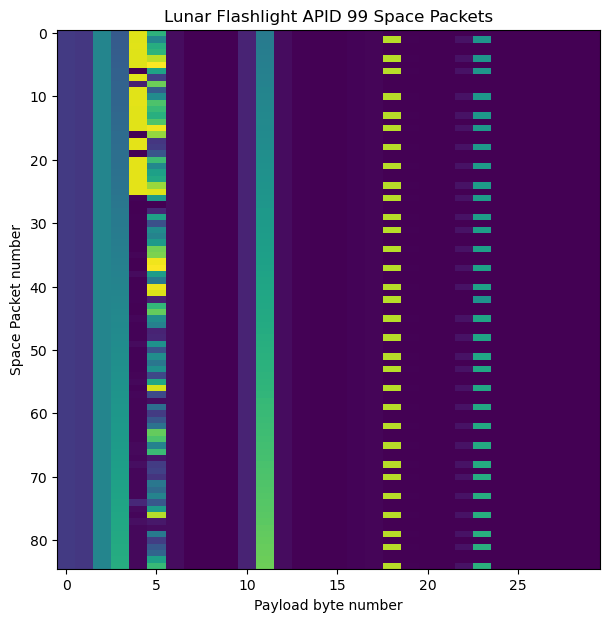

In [16]:
for apid, data in sorted(by_apid.items()):
    plt.figure(figsize=(7, 7))
    plt.imshow(data, aspect='auto', interpolation='none')
    plt.title(f'Lunar Flashlight APID {apid} Space Packets')
    plt.ylabel('Space Packet number')
    plt.xlabel('Payload byte number');

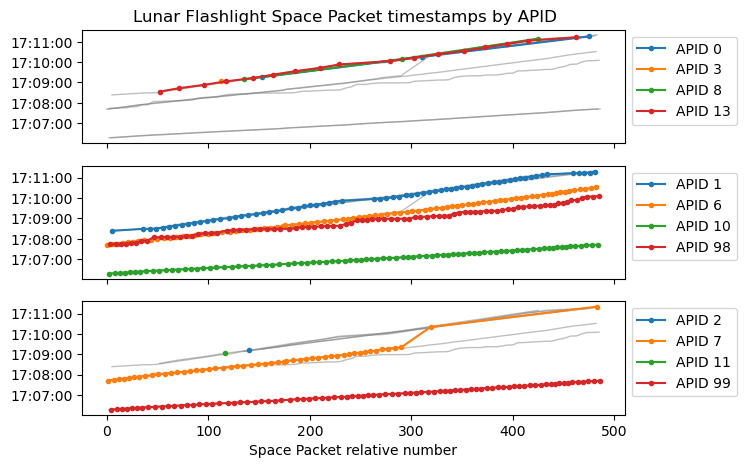

In [17]:
fig, axs = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(7, 5))
for apid in apids:
    for ax in axs:
        ax.plot([j for j, p in enumerate(packet_headers) if p.APID == apid],
                 timestamps(by_apid[apid]), color='gray', linewidth=1, alpha=0.5)
for k, apid in enumerate(sorted(apids)):
    ax = axs[k % len(axs)]
    ax.plot([j for j, p in enumerate(packet_headers) if p.APID == apid],
             timestamps(by_apid[apid]), '.-', label=f'APID {apid}')
for ax in axs:
    ax.legend(bbox_to_anchor=[1, 1])
    ax.yaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.suptitle('Lunar Flashlight Space Packet timestamps by APID', y=0.92)
axs[-1].set_xlabel('Space Packet relative number');

## APID 1

APID 1 contains transmissions of encapsulated Space Packets from APID 113. These contain recorded telemetry data sampled at a rate of one packet every 10 seconds.

In [18]:
np.all(by_apid[1][:, -6:] == 0)

True

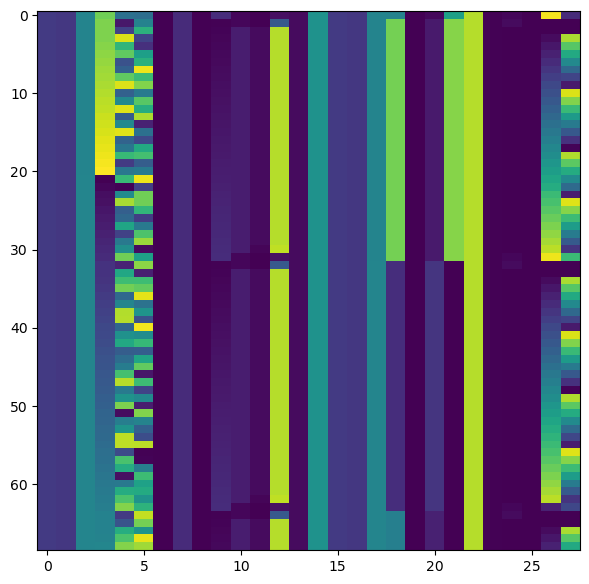

In [19]:
plt.figure(figsize=(7, 7))
plt.imshow(by_apid[1][:, :28], aspect='auto', interpolation='none')

In [20]:
apid_1_segments = [
    np.concatenate((
        by_apid[1][2:23],
        np.zeros((1, len(by_apid[1][0])), 'uint8'), # account for missing packet
        by_apid[1][23:31])),
    by_apid[1][33:63],
    by_apid[1][65:],
]

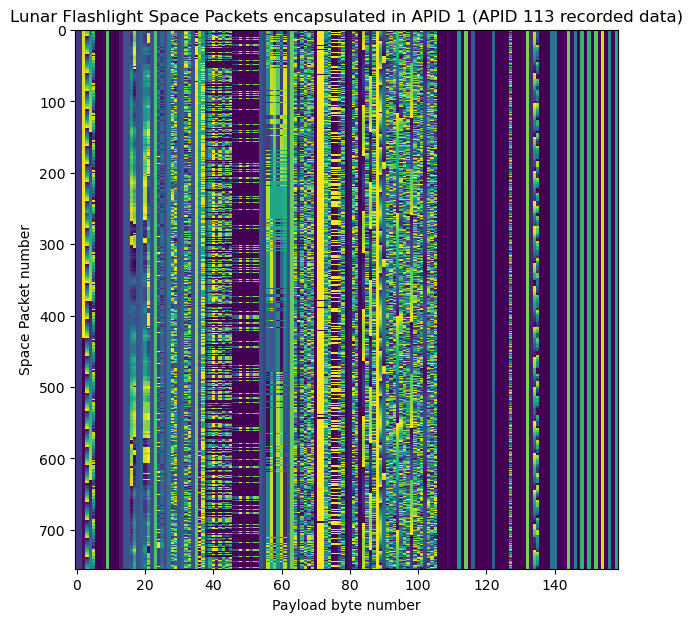

In [21]:
encapsulated = []
packet_size = 165
for segment in apid_1_segments:
    packet_data = segment[:, 28:-6].ravel()
    encapsulated.append(packet_data[:packet_data.size//packet_size*packet_size].reshape(-1, packet_size))
encapsulated = np.concatenate(encapsulated)
# filter out incomplete packets
encapsulated = encapsulated[~np.all(encapsulated[:, :20] == 0, axis=1) 
                            & ~np.all(encapsulated[:, -40:] == 0, axis=1)]
plt.figure(figsize=(7, 7))
plt.imshow(encapsulated[:, 6:], aspect='auto', interpolation='none')
plt.title(f'Lunar Flashlight Space Packets encapsulated in APID 1 (APID 113 recorded data)')
plt.ylabel('Space Packet number')
plt.xlabel('Payload byte number');

In [22]:
encapsulated_headers = [ccsds.SpacePacketPrimaryHeader.parse(p) for p in encapsulated]
encapsulated_headers[:10]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=113, sequence_flags=3, packet_sequence_count_or_name=8319, data_length=158),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=113, sequence_flags=3, packet_sequence_count_or_name=8320, data_length=158),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=113, sequence_flags=3, packet_sequence_count_or_name=8321, data_length=158),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=113, sequence_flags=3, packet_sequence_count_or_name=8322, data_length=158),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=113, sequence_flags=3, packet_sequence_count_or_name=8323, data_length=158),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=113, sequence_flags=3, packet_sequence_count_or_name=8324, data_length=158),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=113, s

In [23]:
{h.APID for h in encapsulated_headers}

{113}

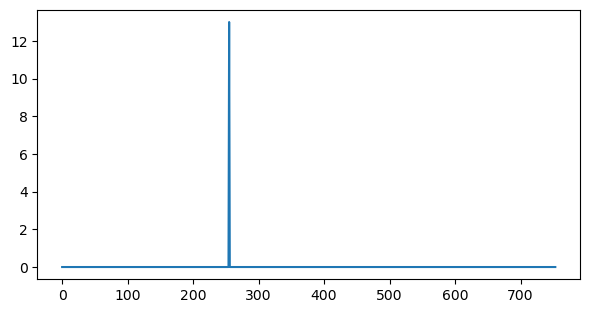

In [24]:
plt.plot(np.diff([h.packet_sequence_count_or_name for h in encapsulated_headers]) - 1)

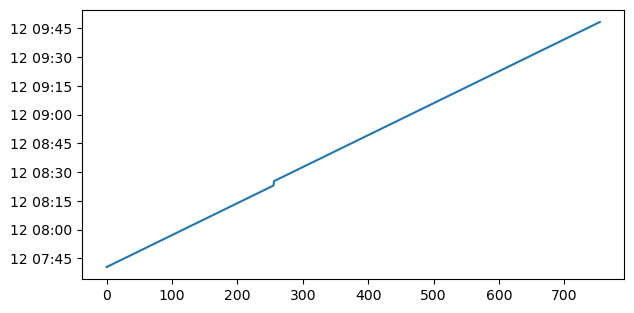

In [25]:
t113 = timestamps(encapsulated[:, 6:])
plt.plot(t113)

In [26]:
t113[0], t113[-1]

(numpy.datetime64('2022-12-12T07:40:29.409011840'),
 numpy.datetime64('2022-12-12T09:48:22.474334720'))

In [27]:
np.diff(t113)/np.timedelta64(1, 's')

array([ 10.00428774,  10.00329587,  10.0043488 ,  10.00328064,
        10.00433344,  10.00332646,  10.00430298,  10.00329587,
        10.00436403,  10.00326541,  10.00433344,  10.00332646,
        10.00430298,  10.00329587,  10.00436403,  10.00325005,
        10.0043488 ,  10.0033417 ,  10.00428774,  10.00329587,
        10.00436403,  10.00325005,  10.00433357,  10.00335693,
        10.00428774,  10.00328064,  10.0043639 ,  10.00326541,
        10.0043488 ,  10.00332634,  10.00430298,  10.00328064,
        10.00437939,  10.00326528,  10.00433357,  10.00332634,
        10.00430298,  10.003296  ,  10.0043639 ,  10.00325018,
        10.0043488 ,  10.00332634,  10.00430298,  10.00328064,
        10.00439462,  10.00323482,  10.0043488 ,  10.00334157,
        10.00428774,  10.00329587,  10.0043488 ,  10.00328064,
        10.0043488 ,  10.0033111 ,  10.00430298,  10.00328064,
        10.00437926,  10.00326541,  10.00433357,  10.00332634,
        10.00430298,  10.00329587,  10.00436403,  10.00

## ADCS telemetry

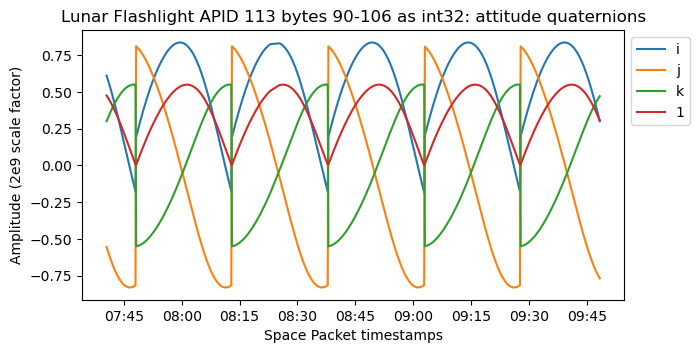

In [28]:
z = encapsulated[:, 6:][:, 90:106].view('int32').byteswap()
z_float = z.astype('float') / 2e9
plt.plot(t113, z_float)
plt.title(f'Lunar Flashlight APID 113 bytes 90-106 as int32: attitude quaternions')
plt.ylabel('Amplitude (2e9 scale factor)')
plt.xlabel('Space Packet timestamps')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.legend(['i', 'j', 'k', '1'], bbox_to_anchor=[1, 1]);

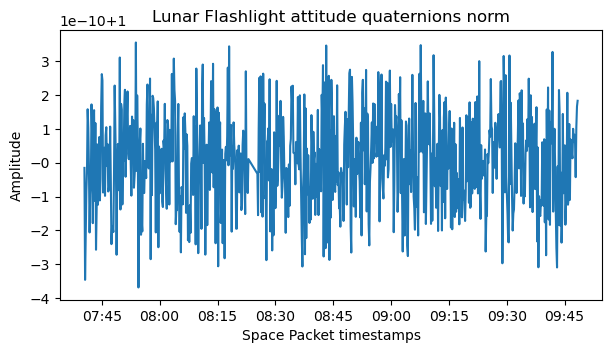

In [29]:
plt.plot(t113, np.sqrt(np.sum(z_float**2, axis=1)))
plt.title(f'Lunar Flashlight attitude quaternions norm')
plt.ylabel('Amplitude')
plt.xlabel('Space Packet timestamps')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'));

/tmp/ipykernel_2939324/635088382.py:4: RuntimeWarning: invalid value encountered in divide
  V /= np.sqrt(np.sum(V**2, axis = -1))[..., np.newaxis]


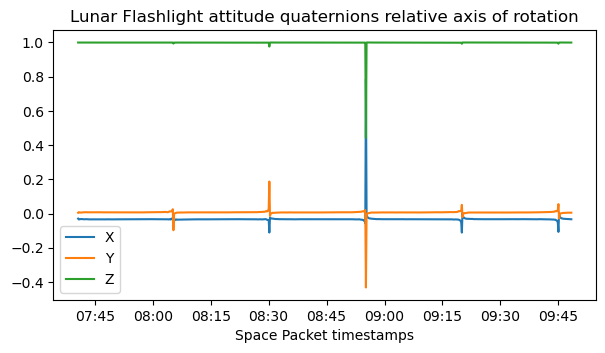

In [30]:
q = Rotation.from_quat(z[:, [0, 1, 2, 3]]) # scalar last format?
h = q.inv()*q[0]
V = h.as_quat()[:,:-1]
V /= np.sqrt(np.sum(V**2, axis = -1))[..., np.newaxis]
V *= np.sign(V[:, -1])[..., np.newaxis]
plt.plot(t113, V)
plt.title(f'Lunar Flashlight attitude quaternions relative axis of rotation')
plt.xlabel('Space Packet timestamps')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.legend(['X', 'Y', 'Z']);

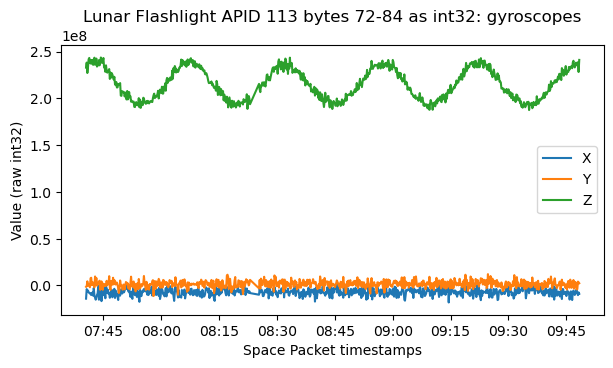

In [31]:
gyros = encapsulated[:, 6:][:, 72:84].view('int32').byteswap().astype('float')
plt.plot(t113, gyros)
plt.title(f'Lunar Flashlight APID 113 bytes 72-84 as int32: gyroscopes')
plt.xlabel('Space Packet timestamps')
plt.ylabel('Value (raw int32)')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.legend(['X', 'Y', 'Z']);

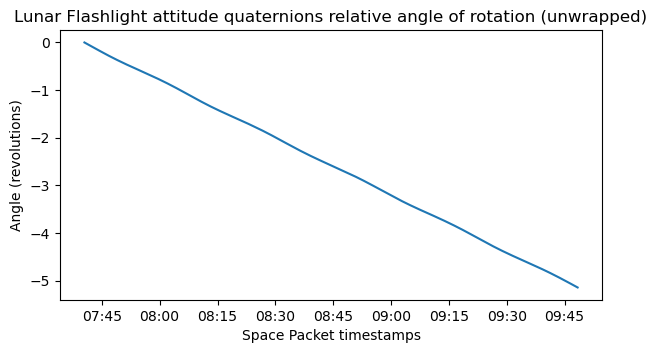

In [32]:
theta = 2 * np.arctan2(np.sqrt(np.sum(h.as_quat()[:,:-1]**2, axis = 1)), h.as_quat()[:,-1])
theta = (theta + np.pi) % (2 * np.pi) - np.pi
theta *= np.sign(h.as_quat()[:, -2])
theta = np.unwrap(theta)
plt.plot(t113, np.rad2deg(theta) / 360)
plt.title(f'Lunar Flashlight attitude quaternions relative angle of rotation (unwrapped)')
plt.ylabel('Angle (revolutions)')
plt.xlabel('Space Packet timestamps')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'));

In [33]:
w_deg_s = np.rad2deg((theta[-1] - theta[0]))/((t113[-1] - t113[0])/np.timedelta64(1, 's'))
w_deg_s

-0.24132301120943545

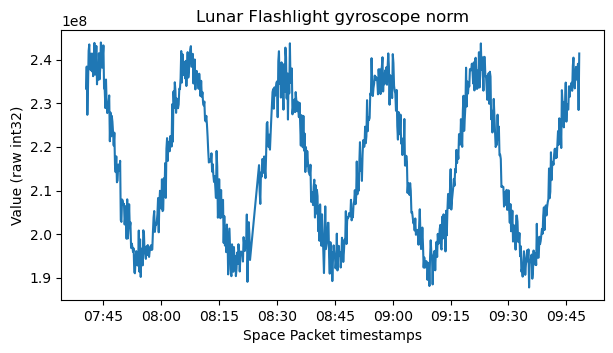

In [34]:
gyro_abs = np.sqrt(np.sum(np.abs(gyros**2), axis=1))
plt.plot(t113, gyro_abs)
plt.title(f'Lunar Flashlight gyroscope norm')
plt.xlabel('Space Packet timestamps')
plt.ylabel('Value (raw int32)')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'));

In [35]:
gyro_scale_factor = w_deg_s / np.average(gyro_abs)
gyro_scale_factor

-1.118214680265811e-09

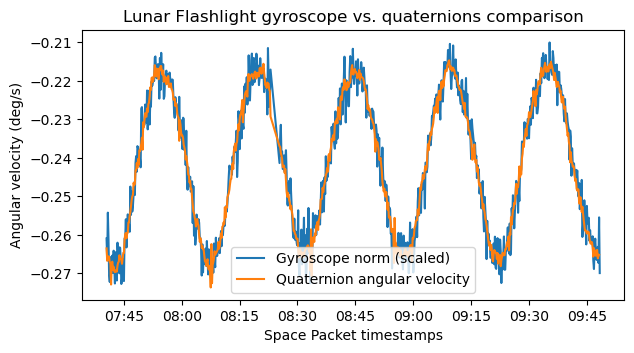

In [36]:
plt.plot(t113, gyro_abs * gyro_scale_factor, label='Gyroscope norm (scaled)')
plt.plot(t113[:-1], np.rad2deg(np.diff(theta)) / (np.diff(t113)/np.timedelta64(1, 's')),
         label='Quaternion angular velocity')
plt.title(f'Lunar Flashlight gyroscope vs. quaternions comparison')
plt.xlabel('Space Packet timestamps')
plt.ylabel('Angular velocity (deg/s)')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.legend();

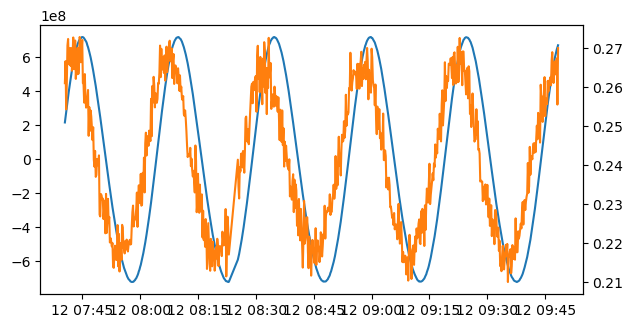

In [37]:
x = encapsulated[:, 6:][:, 86:90].view('int32').byteswap()
plt.plot(t113, x)
ax = plt.twinx()
plt.plot(t113, -gyro_abs * gyro_scale_factor, color='C1')

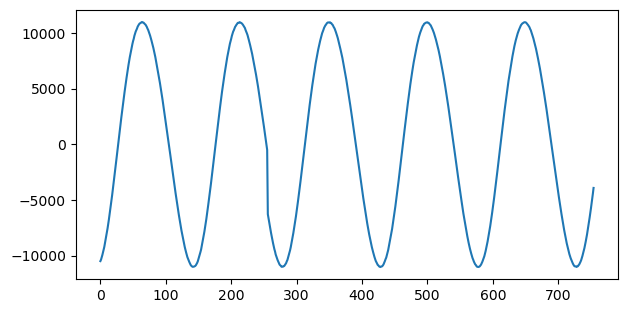

In [38]:
y = encapsulated[:, 6:][:, 84:86].view('int16').byteswap()
plt.plot(y)

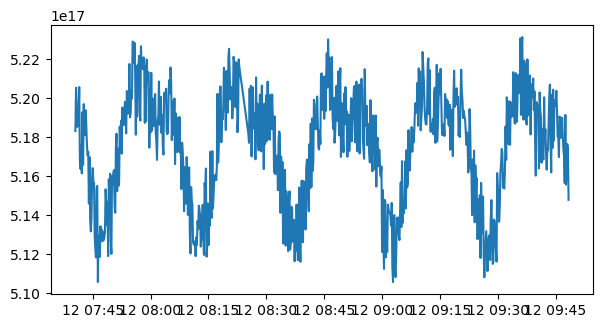

In [39]:
plt.plot(t113, x.astype('float')**2 + y.astype('float')**2*(2**16)**2)

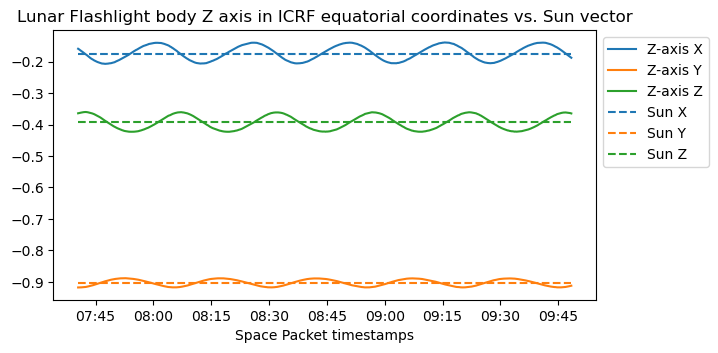

In [40]:
plt.plot(t113, q.apply([0, 0, 1]), label=['Z-axis X', 'Z-axis Y', 'Z-axis Z'])
# data from HORIZONS for 2022-12-12 07:30 TDB
rg = np.array([1.091045737796953E+05, 1.823148698137618E+05, 3.691885635701910E+04]) # geocentric equatorial
rh = np.array([2.588114338496504E+07, 1.332417871033638E+08, 5.771645402418958E+07]) # heliocentric equatorial
for r in rg, rh:
    r /= np.sqrt(np.dot(r, r))
plt.gca().set_prop_cycle(None)
plt.plot([t113[0], t113[-1]], [-rh, -rh], '--', label=['Sun X', 'Sun Y', 'Sun Z'])
plt.xlabel('Space Packet timestamps')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.title('Lunar Flashlight body Z axis in ICRF equatorial coordinates vs. Sun vector')
plt.legend(bbox_to_anchor=[1, 1]);

In [41]:
np.rad2deg(np.arccos(np.dot(rg, rh)))

23.147857148183707

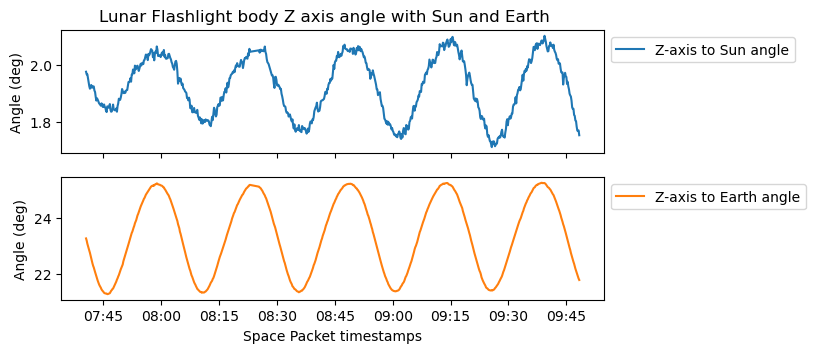

In [42]:
fig, axs = plt.subplots(2, sharex=True)
axs[0].plot(t113, np.rad2deg(np.arccos(np.dot(q.apply([0, 0, 1]), -rh))), label='Z-axis to Sun angle')
axs[1].plot(t113, np.rad2deg(np.arccos(np.dot(q.apply([0, 0, 1]), -rg))), color='C1', label='Z-axis to Earth angle')
axs[1].set_xlabel('Space Packet timestamps')
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
for ax in axs:
    ax.set_ylabel('Angle (deg)');
    ax.legend(bbox_to_anchor=[1, 1])
plt.suptitle('Lunar Flashlight body Z axis angle with Sun and Earth', y=0.94);